SETUP

In [8]:
import os, ast, json, random, numpy as np, pandas as pd, wfdb, tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, f1_score
tf.random.set_seed(42); np.random.seed(42); random.seed(42)


In [9]:
PTBXL_ROOT = "/Users/sahandissanayake/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
ptbxl_csv = os.path.join(PTBXL_ROOT, "ptbxl_database.csv")
scp_csv   = os.path.join(PTBXL_ROOT, "scp_statements.csv")
assert os.path.exists(ptbxl_csv) and os.path.exists(scp_csv), "Check PTB-XL paths."

In [10]:
df = pd.read_csv(ptbxl_csv)
scp_df = pd.read_csv(scp_csv)

# Normalize columns; ensure we have ['scp','diagnostic_class']
scp_df = scp_df.copy()
scp_df.columns = scp_df.columns.str.strip()
if "scp" not in scp_df.columns:
    if "Unnamed: 0" in scp_df.columns:
        scp_df = scp_df.rename(columns={"Unnamed: 0": "scp"})
    elif scp_df.index.name:
        scp_df = scp_df.reset_index().rename(columns={scp_df.columns[0]: "scp"})
    else:
        # fallback: use first non-diagnostic_class column as scp
        candidates = [c for c in scp_df.columns if c != "diagnostic_class"]
        scp_df = scp_df.rename(columns={candidates[0]: "scp"})

assert "scp" in scp_df.columns, f"Missing 'scp' column: {scp_df.columns.tolist()}"
assert "diagnostic_class" in scp_df.columns, "'diagnostic_class' column missing."

# Build mapping: SCP code -> diagnostic_class (NORM/MI/STTC/HYP/CD)
scp_df["scp"] = scp_df["scp"].astype(str).str.strip()
scp_df["diagnostic_class"] = scp_df["diagnostic_class"].astype(str).str.strip()
scp_to_class = dict(zip(scp_df["scp"], scp_df["diagnostic_class"]))


In [11]:
import ast
from sklearn.preprocessing import LabelEncoder

# Binary mapping: NORM → NORMAL, everything else → ABNORMAL
scp_to_class = {
    "NORM": "NORMAL",     # Normal ECG
    "MI": "ABNORMAL",     # Myocardial Infarction
    "STTC": "ABNORMAL",   # ST/T changes
    "HYP": "ABNORMAL",    # Hypertrophy
    "CD": "ABNORMAL",     # Conduction Disturbance
    "SBRAD": "ABNORMAL",
    "LAFB": "ABNORMAL",
    "LBBB": "ABNORMAL",
    "RBBB": "ABNORMAL",
    "IRBBB": "ABNORMAL",
    "CRBBB": "ABNORMAL",
    "AVB": "ABNORMAL",
    "PVC": "ABNORMAL",
    "PAC": "ABNORMAL",
    "LAE": "ABNORMAL",
    "LVH": "ABNORMAL",
    "RAE": "ABNORMAL",
    "RVH": "ABNORMAL",
    "ISC": "ABNORMAL",
    "IMI": "ABNORMAL",
    "ILMI": "ABNORMAL",
    "ILAF": "ABNORMAL",
    "ASMI": "ABNORMAL",
    "INMI": "ABNORMAL",
    "STACH": "ABNORMAL",
    "NST": "ABNORMAL",
    "TINV": "ABNORMAL",
    "STDEP": "ABNORMAL",
    "STEMI": "ABNORMAL",
    "STD": "ABNORMAL",
    "TNEG": "ABNORMAL",
    "STEL": "ABNORMAL",
    "SVT": "ABNORMAL",
    "AFIB": "ABNORMAL",
    "AFL": "ABNORMAL",
}

def parse_scp_codes(s):
    if isinstance(s, dict):
        return s
    if isinstance(s, str):
        try:
            return ast.literal_eval(s)
        except Exception:
            return {}
    return {}

def majority_diag_class(scp_codes_dict):
    """Binary: if ANY abnormal code exists, return ABNORMAL"""
    for scp, w in scp_codes_dict.items():
        dc = scp_to_class.get(str(scp))
        if dc == "ABNORMAL":
            return "ABNORMAL"
    return "NORMAL"

# Check required columns
required_cols = {"scp_codes", "strat_fold", "filename_lr"}
assert required_cols.issubset(df.columns), f"Missing columns: {required_cols - set(df.columns)}"

df = df.copy()
df["scp_codes_dict"] = df["scp_codes"].apply(parse_scp_codes)
df["y_class"] = df["scp_codes_dict"].apply(majority_diag_class)
df = df.dropna(subset=["y_class"]).reset_index(drop=True)

# Encode to binary (0 or 1)
le = LabelEncoder()
le.fit(df["y_class"])
df["y_int"] = le.transform(df["y_class"]).astype("int32")
n_classes = len(le.classes_)  # Should be 2

print("BINARY CLASSIFICATION SETUP")
print(f"Classes → ids: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"Number of classes: {n_classes}")

# Create path column
df["record_path"] = df["filename_lr"]

# Patient-wise split
train_idx = df["strat_fold"].isin(range(1, 9))
val_idx   = df["strat_fold"].eq(9)
test_idx  = df["strat_fold"].eq(10)

df_train = df[train_idx].copy()
df_val   = df[val_idx].copy()
df_test  = df[test_idx].copy()

print(f"\n📊 Dataset Distribution:")
for name, d in [("train", df_train), ("val", df_val), ("test", df_test)]:
    counts = d['y_class'].value_counts().to_dict()
    print(f"{name:6}: {len(d):5} samples | {counts}")

BINARY CLASSIFICATION SETUP
Classes → ids: {'ABNORMAL': np.int64(0), 'NORMAL': np.int64(1)}
Number of classes: 2

📊 Dataset Distribution:
train : 17441 samples | {'NORMAL': 9179, 'ABNORMAL': 8262}
val   :  2193 samples | {'NORMAL': 1193, 'ABNORMAL': 1000}
test  :  2203 samples | {'NORMAL': 1179, 'ABNORMAL': 1024}


In [12]:
from tensorflow.keras import layers, Model

INPUT_LEN, N_LEADS, BATCH = 1000, 12, 64

def se_block(x, r=16):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling1D()(x)
    s = layers.Dense(max(1, c//r), activation="relu")(s)
    s = layers.Dense(c, activation="sigmoid")(s)
    return layers.Multiply()([x, layers.Reshape((1, c))(s)])

def res_block(x, filters, kernel=7, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    x = layers.Conv1D(filters, kernel, padding="same")(x)
    x = layers.BatchNormalization()(x); x = se_block(x)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut]); x = layers.Activation("relu")(x)
    return x

def build_binary_ecg_model(input_len=1000, n_leads=12):
    """Binary classification: Normal vs Abnormal"""
    inp = layers.Input(shape=(input_len, n_leads))
    x = layers.Conv1D(32, 7, padding="same")(inp)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)

    x = res_block(x, 32, 7, 1)
    x = res_block(x, 64, 7, 2)
    x = res_block(x, 64, 7, 1)
    x = res_block(x, 128, 7, 2)
    x = res_block(x, 128, 7, 1)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    # Binary output with sigmoid
    out = layers.Dense(1, activation="sigmoid")(x)
    return Model(inp, out)

model = build_binary_ecg_model(INPUT_LEN, N_LEADS)

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

print("Binary ECG Model Created")
model.summary()

Binary ECG Model Created


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1000, 32)  │      2,720 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 1000, 32)  │      7,200 │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 1000, 32)  │      7,200 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │         96 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 32)     │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 1000, 32)  │          0 │ multiply_5[0][0], │
│                     │                   │            │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 1000, 32)  │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 500, 64)   │     14,400 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 500, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 548,315 (2.09 MB)

 Trainable params: 546,203 (2.08 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [13]:
AUTO = tf.data.AUTOTUNE

def read_wfdb_record(rel_wo_ext, root=PTBXL_ROOT):
    p = os.path.join(root, rel_wo_ext)
    sig, _ = wfdb.rdsamp(p)
    return sig.astype(np.float32)

def augment_ecg_binary(sig, y_int):
    """Augmentation for binary classification"""
    sig = sig.copy()
    
    # Check which class (0 or 1)
    abnormal_label = le.transform(["ABNORMAL"])[0]
    is_abnormal = (y_int == abnormal_label)
    aug_prob = 0.7 if is_abnormal else 0.5
    
    # 1. Amplitude Scaling
    if np.random.rand() < aug_prob:
        scale = np.random.uniform(0.85, 1.15)
        sig = sig * scale
    
    # 2. Gaussian Noise
    if np.random.rand() < aug_prob:
        noise = np.random.normal(0, 0.05, sig.shape)
        sig = sig + noise
    
    # 3. Baseline Wander
    if np.random.rand() < 0.5:
        freq = np.random.uniform(0.2, 1.0)
        t = np.linspace(0, 10, INPUT_LEN)
        baseline = 0.1 * np.sin(2 * np.pi * freq * t)
        sig = sig + baseline[:, None]
    
    # 4. Time shift
    if np.random.rand() < 0.3:
        shift = np.random.randint(-50, 50)
        sig = np.roll(sig, shift, axis=0)
    
    return sig

def _py_load_binary(path_bytes, y_int, augment=False):
    path = path_bytes.numpy().decode("utf-8")
    sig = read_wfdb_record(path)
    
    # Pad/trim
    if sig.shape != (INPUT_LEN, N_LEADS):
        out = np.zeros((INPUT_LEN, N_LEADS), np.float32)
        T = min(INPUT_LEN, sig.shape[0]); C = min(N_LEADS, sig.shape[1])
        out[:T, :C] = sig[:T, :C]
        sig = out
    
    # Augmentation
    if augment:
        sig = augment_ecg_binary(sig, y_int)
    
    # Z-score normalization
    m = sig.mean(0, keepdims=True)
    s = sig.std(0, keepdims=True) + 1e-6
    sig = (sig - m) / s
    
    return sig.astype(np.float32), np.float32(y_int)

def make_binary_ds(df_part, shuffle=False, augment=False):
    paths = df_part["record_path"].tolist()
    ys = df_part["y_int"].astype("float32").tolist()
    
    ds = tf.data.Dataset.from_tensor_slices((paths, ys))
    ds = ds.map(
        lambda p, y: tf.py_function(
            lambda p, y: _py_load_binary(p, y, augment=augment),
            [p, y],
            [tf.float32, tf.float32]
        ),
        num_parallel_calls=AUTO
    )
    ds = ds.map(
        lambda x, y: (
            tf.ensure_shape(x, [INPUT_LEN, N_LEADS]),
            tf.ensure_shape(y, [])
        ),
        num_parallel_calls=AUTO
    )
    if shuffle:
        ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(AUTO)

# Create datasets
train_ds = make_binary_ds(df_train, shuffle=True, augment=True)
val_ds = make_binary_ds(df_val, shuffle=False, augment=False)
test_ds = make_binary_ds(df_test, shuffle=False, augment=False)

print("Binary datasets created")
for xb, yb in train_ds.take(1):
    print(f"   Train batch: x={xb.shape}, y={yb.shape}")

Binary datasets created
   Train batch: x=(64, 1000, 12), y=(64,)


2025-11-06 15:07:07.074780: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
from sklearn.utils.class_weight import compute_class_weight

# Binary class weights
classes = np.array([0, 1])
cw = compute_class_weight(
    class_weight="balanced", 
    classes=classes, 
    y=df_train["y_int"].values
)
class_weight = {int(k): float(v) for k, v in zip(classes, cw)}
print(f"📊 Class weights: {class_weight}")
print(f"   {le.classes_[0]}: {class_weight[0]:.2f}")
print(f"   {le.classes_[1]}: {class_weight[1]:.2f}")

# Checkpoint path
ckpt_path = "/Users/sahandissanayake/Documents/PythonLib 3.11/models/best_ptbxl_binary.keras"
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)

# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 3:
        return 3e-4 * (epoch + 1) / 3
    else:
        return 3e-4 * 0.5 * (1 + np.cos(np.pi * (epoch - 3) / 27))

# Callbacks
cbs = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
]

print("🚀 Starting binary classification training...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight,
    callbacks=cbs,
    verbose=1
)

print("Training complete!")

📊 Class weights: {0: 1.0554950375211813, 1: 0.9500490249482515}
   ABNORMAL: 1.06
   NORMAL: 0.95
🚀 Starting binary classification training...

Epoch 1: LearningRateScheduler setting learning rate to 9.999999999999999e-05.
Epoch 1/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6432 - auc: 0.7066 - loss: 0.6306 - precision: 0.6952 - recall: 0.6132
Epoch 1: val_auc improved from None to 0.83075, saving model to /Users/sahandissanayake/Documents/PythonLib 3.11/models/best_ptbxl_binary.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 80s 259ms/step - accuracy: 0.7140 - auc: 0.7849 - loss: 0.5587 - precision: 0.7278 - recall: 0.7294 - val_accuracy: 0.6156 - val_auc: 0.8308 - val_loss: 0.7729 - val_precision: 0.5865 - val_recall: 0.9941 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999999999998.
Epoch 2/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7711 - auc: 0.8468 - loss: 0.4817 - precision: 0.7754 - recall: 0.8152
Epoch 2: val

2025-11-06 15:43:44.521940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 4053 of 4096
2025-11-06 15:43:44.615495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8645 - auc: 0.9359 - loss: 0.3234 - precision: 0.8745 - recall: 0.8793 
Epoch 12: val_auc improved from 0.90764 to 0.91024, saving model to /Users/sahandissanayake/Documents/PythonLib 3.11/models/best_ptbxl_binary.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 8779s 30s/step - accuracy: 0.8666 - auc: 0.9390 - loss: 0.3147 - precision: 0.8667 - recall: 0.8821 - val_accuracy: 0.8345 - val_auc: 0.9102 - val_loss: 0.3942 - val_precision: 0.8347 - val_recall: 0.8676 - learning_rate: 2.3957e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.000225.
Epoch 13/30


2025-11-06 18:16:26.008662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 1256 of 4096
2025-11-06 18:16:30.825691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8625 - auc: 0.9380 - loss: 0.3186 - precision: 0.8762 - recall: 0.8735
Epoch 13: val_auc did not improve from 0.91024
273/273 ━━━━━━━━━━━━━━━━━━━━ 1302s 1s/step - accuracy: 0.8690 - auc: 0.9405 - loss: 0.3122 - precision: 0.8707 - recall: 0.8822 - val_accuracy: 0.8267 - val_auc: 0.9035 - val_loss: 0.4074 - val_precision: 0.8430 - val_recall: 0.8374 - learning_rate: 2.2500e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002094119649058735.
Epoch 14/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8738 - auc: 0.9434 - loss: 0.3030 - precision: 0.8810 - recall: 0.8902
Epoch 14: val_auc did not improve from 0.91024
273/273 ━━━━━━━━━━━━━━━━━━━━ 75s 257ms/step - accuracy: 0.8741 - auc: 0.9447 - loss: 0.2995 - precision: 0.8731 - recall: 0.8903 - val_accuracy: 0.7706 - val_auc: 0.8900 - val_loss: 0.6103 - val_precision: 0.8791 - val_recall: 0.6706 - learning_rate: 2.0941e-04

Epoch 15: LearningRateScheduler sett

2025-11-06 18:51:44.072341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 4069 of 4096
2025-11-06 18:51:44.189832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8872 - auc: 0.9540 - loss: 0.2713 - precision: 0.8921 - recall: 0.9026
Epoch 18: val_auc did not improve from 0.91024
273/273 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.8907 - auc: 0.9569 - loss: 0.2640 - precision: 0.8894 - recall: 0.9048 - val_accuracy: 0.8340 - val_auc: 0.9038 - val_loss: 0.4475 - val_precision: 0.8128 - val_recall: 0.9028 - learning_rate: 1.4128e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00012395277334996047.
Epoch 19/30
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8887 - auc: 0.9574 - loss: 0.2610 - precision: 0.8950 - recall: 0.9026
Epoch 19: val_auc did not improve from 0.91024
273/273 ━━━━━━━━━━━━━━━━━━━━ 75s 257ms/step - accuracy: 0.8923 - auc: 0.9588 - loss: 0.2576 - precision: 0.8896 - recall: 0.9081 - val_accuracy: 0.8181 - val_auc: 0.9023 - val_loss: 0.4510 - val_precision: 0.7902 - val_recall: 0.9061 - learning_rate: 1.2395e-04

Epoch 20: LearningRateScheduler sett

In [15]:
from tensorflow import keras

model = keras.models.load_model(
    "/Users/sahandissanayake/Documents/PythonLib 3.11/models/best_ptbxl_binary.keras"
)
print("Binary model loaded!")

Binary model loaded!


BINARY MODEL EVALUATION
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8320 - auc: 0.9025 - loss: 0.4139 - precision: 0.8270 - recall: 0.8677

Test Accuracy:  0.8320 (83.20%)
Test Precision: 0.8270
Test Recall:    0.8677
Test AUC:       0.9025

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    ABNORMAL     0.8385    0.7910    0.8141      1024
      NORMAL     0.8270    0.8677    0.8469      1179

    accuracy                         0.8320      2203
   macro avg     0.8328    0.8294    0.8305      2203
weighted avg     0.8324    0.8320    0.8316      2203


CONFUSION MATRIX
[[ 810  214]
 [ 156 1023]]

ABNORMAL   | TN= 810 | FP= 214
NORMAL     | FN= 156 | TP=1023


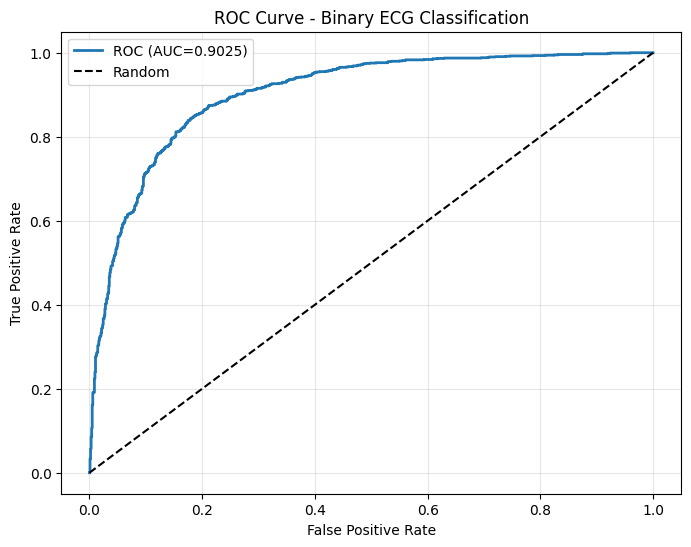

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Recreate test dataset
test_ds = make_binary_ds(df_test, shuffle=False, augment=False)

print("="*60)
print("BINARY MODEL EVALUATION")
print("="*60)

results = model.evaluate(test_ds, return_dict=True)
print(f"\nTest Accuracy:  {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
print(f"Test Precision: {results['precision']:.4f}")
print(f"Test Recall:    {results['recall']:.4f}")
print(f"Test AUC:       {results['auc']:.4f}")

# Get predictions
y_true = df_test["y_int"].values
y_pred_prob = model.predict(test_ds, verbose=0).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

# Confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(f"\n{le.classes_[0]:10} | TN={cm[0,0]:4} | FP={cm[0,1]:4}")
print(f"{le.classes_[1]:10} | FN={cm[1,0]:4} | TP={cm[1,1]:4}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc_score = roc_auc_score(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary ECG Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
def predict_binary_diagnosis(rel_wo_ext):
    """Predict Normal vs Abnormal"""
    sig = read_wfdb_record(rel_wo_ext)
    
    # Preprocess
    if sig.shape != (INPUT_LEN, N_LEADS):
        out = np.zeros((INPUT_LEN, N_LEADS), np.float32)
        T = min(INPUT_LEN, sig.shape[0]); C = min(N_LEADS, sig.shape[1])
        out[:T, :C] = sig[:T, :C]
        sig = out
    
    m, s = sig.mean(0, keepdims=True), sig.std(0, keepdims=True) + 1e-6
    sig = (sig - m) / s
    
    # Predict
    prob = model.predict(sig[None, ...], verbose=0)[0][0]
    pred_class = le.classes_[1] if prob > 0.5 else le.classes_[0]
    
    return {
        "prediction": pred_class,
        "confidence": float(max(prob, 1-prob)),
        f"{le.classes_[0]}_probability": float(1 - prob),
        f"{le.classes_[1]}_probability": float(prob)
    }

# Test predictions
print("Example predictions:")
for i in [0, 1, 27, 34]:
    result = predict_binary_diagnosis(df_test.iloc[i]["record_path"])
    true_class = le.classes_[df_test.iloc[i]["y_int"]]
    match = "✅" if result["prediction"] == true_class else "❌"
    print(f"\n{match} Record {i}: True={true_class}")
    print(f"   {result}")

Example predictions:

✅ Record 0: True=NORMAL
   {'prediction': 'NORMAL', 'confidence': 0.998207688331604, 'ABNORMAL_probability': 0.001792311668395996, 'NORMAL_probability': 0.998207688331604}

✅ Record 1: True=NORMAL
   {'prediction': 'NORMAL', 'confidence': 0.5420249104499817, 'ABNORMAL_probability': 0.4579750895500183, 'NORMAL_probability': 0.5420249104499817}

✅ Record 27: True=ABNORMAL
   {'prediction': 'ABNORMAL', 'confidence': 0.5073937177658081, 'ABNORMAL_probability': 0.5073937177658081, 'NORMAL_probability': 0.4926062524318695}

✅ Record 34: True=ABNORMAL
   {'prediction': 'ABNORMAL', 'confidence': 0.6781120300292969, 'ABNORMAL_probability': 0.6781120300292969, 'NORMAL_probability': 0.32188794016838074}


In [19]:
# Example predictions using the binary function
print("Prediction for the first record in the test set:")
result1 = predict_binary_diagnosis(df_test.iloc[27]["record_path"])
print(result1)

print("\nPrediction for the second record in the test set:")
result2 = predict_binary_diagnosis(df_test.iloc[34]["record_path"])
print(result2)

Prediction for the first record in the test set:
{'prediction': 'ABNORMAL', 'confidence': 0.5073937177658081, 'ABNORMAL_probability': 0.5073937177658081, 'NORMAL_probability': 0.4926062524318695}

Prediction for the second record in the test set:
{'prediction': 'ABNORMAL', 'confidence': 0.6781120300292969, 'ABNORMAL_probability': 0.6781120300292969, 'NORMAL_probability': 0.32188794016838074}


In [21]:
import numpy as np
import wfdb
import pandas as pd
import scipy.io
import os
import json

def load_ecg_file(file_path):
    ext = os.path.splitext(file_path)[-1].lower()
    if ext in ['.dat', '.hea', '']:  # WFDB (assumes .dat/.hea, no extension)
        sig, _ = wfdb.rdsamp(file_path)
        return sig
    elif ext == '.csv':
        df = pd.read_csv(file_path)
        sig = df.select_dtypes(include=[np.number]).values
        return sig
    elif ext == '.npy':
        sig = np.load(file_path)
        return sig
    elif ext == '.mat':
        mat = scipy.io.loadmat(file_path)
        for key in ['ecg', 'signal', 'val', 'data']:
            if key in mat:
                return np.array(mat[key])
        raise ValueError("MAT file: No ECG signal found in keys.")
    elif ext == '.json':
        with open(file_path, 'r') as f:
            jdata = json.load(f)
        # Try common keys for ECG data
        for key in ['ecg', 'signal', 'val', 'data']:
            if key in jdata:
                sig = np.array(jdata[key])
                if sig.ndim == 1:  # Single lead or flat, make shape (T, 1)
                    sig = sig.reshape(-1, 1)
                return sig
        # If top-level is a list (not dict), treat as signal array
        if isinstance(jdata, list):
            sig = np.array(jdata)
            if sig.ndim == 1:
                sig = sig.reshape(-1, 1)
            return sig
        raise ValueError("JSON file: No ECG signal found in keys or top-level list.")
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

def preprocess_ecg(sig, input_len=1000, n_leads=12):
    sig = np.asarray(sig, dtype=np.float32)
    out = np.zeros((input_len, n_leads), np.float32)
    T = min(input_len, sig.shape[0])
    C = min(n_leads, sig.shape[1])
    out[:T, :C] = sig[:T, :C]
    m = out.mean(0, keepdims=True)
    s = out.std(0, keepdims=True) + 1e-6
    out = (out - m) / s
    return out

def predict_cvd(file_path, model, label_encoder, input_len=1000, n_leads=12):
    """Predict binary (Normal/Abnormal) from external ECG file"""
    sig = load_ecg_file(file_path)
    sig = preprocess_ecg(sig, input_len=input_len, n_leads=n_leads)
    
    # Binary prediction
    prob = model.predict(sig[None, ...], verbose=0)[0][0]
    pred_class = label_encoder.classes_[1] if prob > 0.5 else label_encoder.classes_[0]
    
    return {
        'pred_class': pred_class,
        'confidence': float(max(prob, 1-prob)),
        'probs': {
            label_encoder.classes_[0]: float(1 - prob),
            label_encoder.classes_[1]: float(prob)
        }
    }

# Test with an actual PTB-XL record (already preprocessed by the model)
# This uses the existing predict_diagnosis_from_wfdb function instead
test_record_path = df_test.iloc[0]["record_path"]
print("Testing with PTB-XL record:")
print(predict_binary_diagnosis(test_record_path))

Testing with PTB-XL record:
{'prediction': 'NORMAL', 'confidence': 0.998207688331604, 'ABNORMAL_probability': 0.001792311668395996, 'NORMAL_probability': 0.998207688331604}


In [22]:
# Example: Predict from external file
my_file = "/Users/sahandissanayake/Documents/my_ecg_file.mat"  # or .csv, .npy, .json

if os.path.exists(my_file):
    prediction = predict_cvd(my_file, model, le)
    print(prediction)
else:
    print(f"File not found. Please update the path.")
    print("Using PTB-XL test example instead:")
    print(predict_binary_diagnosis(df_test.iloc[0]["record_path"]))

File not found. Please update the path.
Using PTB-XL test example instead:
{'prediction': 'NORMAL', 'confidence': 0.998207688331604, 'ABNORMAL_probability': 0.001792311668395996, 'NORMAL_probability': 0.998207688331604}
